In [1]:
import numpy as np
import bisect

## Non stationary Environment

In [2]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

In [3]:
class NonStationnary(Environment):
  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,
              time_abrupt_change_1, time_abrupt_change_2):
    super().__init__(n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost)
    self.time_abrupt_change_1 = time_abrupt_change_1
    self.time_abrupt_change_2 = time_abrupt_change_2
    
  def pricing_round(self, pulled_price):
    print("Error: Non-stationnary environment needs the time to know the conversion rates!")
    return float("NaN")
    
  def pricing_round(self, pulled_price, time):
    if time < self.time_abrupt_change_1:
      reward_price = np.random.binomial(1,self.probabilities[0,pulled_price])
    elif time < self.time_abrupt_change_2:
      reward_price = np.random.binomial(1,self.probabilities[1,pulled_price])
    else:
      reward_price = np.random.binomial(1,self.probabilities[2,pulled_price])
    return reward_price
    

## Pricing 

In [4]:
class ucb_learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [5]:
class TS_Pricing_Learner(ucb_learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [6]:
class UCB_Pricing_Learner(ucb_learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    L = len(self.rewards_per_arm[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(L - 1) + reward*self.prices[pulled_arm] ) / L
    for a in range(self.n_arms):
      L = len(self.rewards_per_arm[a])
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/L) if L > 0 else 1e3

In [7]:
class SW_UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices, tau=np.sqrt(1000*365)):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)
    self.tau = tau                                        # parameter for the confidence bound
    self.arm_window = []                                  # window of the last arms played
    self.nb_w_samples_per_arm = [0 for _ in range(n_arms)] # number of samples in each arm window 
    self.last_reward_arm_out = -1                         # last arm that went out of the arm window
  
  def empirical_means_in_range(self, pulled_arm):
    count = self.nb_w_samples_per_arm[pulled_arm]
    if count == 0:
      return 0
    
    return sum(self.rewards_per_arm[pulled_arm])/count

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    
    for a in range(self.n_arms):
      if self.nb_w_samples_per_arm[a] == 0:
        return a

    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

  def update_observations(self, pulled_arm, reward):
    self.arm_window.append(pulled_arm)
    self.rewards_per_arm[pulled_arm].append(reward)
    self.nb_w_samples_per_arm[pulled_arm] += 1
    if self.t > self.tau:
      self.last_reward_arm_out = self.arm_window.pop(0)
      self.rewards_per_arm[self.last_reward_arm_out].pop(0)
      self.nb_w_samples_per_arm[self.last_reward_arm_out] -= 1
    
    self.collected_rewards = np.append(self.collected_rewards,reward)

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = self.empirical_means_in_range(pulled_arm)
    for a in range(self.n_arms):
      nb_samples_t_1_tau = self.nb_w_samples_per_arm[a]
      if (a == pulled_arm):
        nb_samples_t_1_tau -= 1 
      if (a == self.last_reward_arm_out):
        nb_samples_t_1_tau += 1
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/nb_samples_t_1_tau) if nb_samples_t_1_tau > 0 else 1e3

NameError: name 'Learner' is not defined

## Simulation

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [ ]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.5,0.2,0.1,0.1,0.1],
              [0.1,0.1,0.1,0.2,0.5]])             # bernoulli distributions for the reward functions

time_abrupt_change_1 = 100
time_abrupt_change_2 = 200
opt_rate_0 = p[0, np.argmax(p[0,:]*prices)]                 # optimal arm
opt_rate_1 = p[1, np.argmax(p[1,:]*prices)] 
opt_rate_2 = p[2, np.argmax(p[2,:]*prices)] 
print("Pricing (optimal price):")
print("Before change:")
print(" idx: " + str(np.argmax(p[0,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[0,:]*prices)]) + 
      "  rate: " + str(opt_rate_0) + 
      "  price*rate: " + str(opt_rate_0*prices[np.argmax(p[0,:]*prices)]))
print("After 1 change:")
print(" idx: " + str(np.argmax(p[1,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[1,:]*prices)]) + 
      "  rate: " + str(opt_rate_1) + 
      "  price*rate: " + str(opt_rate_1*prices[np.argmax(p[1,:]*prices)]))
print("After 2 changes:")
print(" idx: " + str(np.argmax(p[2,:]*prices)) + 
      "  price: " + str(prices[np.argmax(p[2,:]*prices)]) + 
      "  rate: " + str(opt_rate_2) + 
      "  price*rate: " + str(opt_rate_2*prices[np.argmax(p[2,:]*prices)]))

Pricing (optimal price):
Before change:
 idx: 3  price: 8  rate: 0.35  price*rate: 2.8
After 1 change:
 idx: 0  price: 5  rate: 0.5  price*rate: 2.5
After 2 changes:
 idx: 4  price: 9  rate: 0.5  price*rate: 4.5


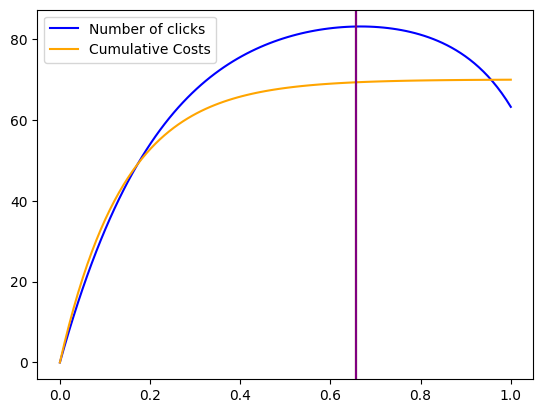

In [ ]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid_0 = bids[np.argmax(opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_1 = bids[np.argmax(opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(bids)-costs(bids))]
opt_bid_2 = bids[np.argmax(opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid_0,c='red')
ax.axvline(opt_bid_1,c='green')
ax.axvline(opt_bid_2,c='purple')
# print("Advertising (optimal bid):")
# print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## Known advertising

We are looking for the best $\tau$

In [ ]:
def generate_logarithmic_array(start, end, size):
    x = np.linspace(0, 1, size)  # Generate a sequence of 20 points between 0 and 1
    values = np.exp(x * np.log(end / start))  # Apply the logarithmic transformation
    values = start + (end - start) * (values - np.min(values)) / (np.max(values) - np.min(values))  # Rescale the values between start and end
    return values.astype(int)  # Convert the values to integers

In [ ]:
n_experiments = 10  #CHECK FOR DIFFERENT VALUES OF n_experiments
taus = generate_logarithmic_array(20000,200000,5) # FIND THE BEST TAU

# sw_ucb_rewards_per_experiment_per_tau = np.empty((len(taus), n_experiments))
sw_ucb_rewards_per_experiment_per_tau = []
# print(sw_ucb_rewards_per_experiment_per_tau.shape)
# print(sw_ucb_rewards_per_experiment_per_tau)

taus = [100000, 200000,300000]
for tau in tqdm(taus):
    sw_ucb_rewards_per_experiment = []
    for e in tqdm(range(n_experiments)):
        env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
        ucb_learner = SW_UCB_Pricing_Learner(n_prices, prices, tau)

        sw_ucb_collected_costs = np.array([])
        sw_ucb_daily_pricing_reward = np.array([])
        
        for t in range(T):
            pulled_bid = np.argmax(clicks(bids)-costs(bids))
            reward_click, reward_cost = env.bidding_round(pulled_bid)
            sw_ucb_collected_costs = np.append(sw_ucb_collected_costs, reward_cost)

            for k in range(reward_click):
                pulled_price = ucb_learner.pull_arm()
                reward_price = env.pricing_round(pulled_price, t)
                ucb_learner.update(pulled_price, reward_price)
            sw_ucb_daily_pricing_reward = np.append(sw_ucb_daily_pricing_reward,(reward_click>0)*np.sum(ucb_learner.collected_rewards[-reward_click:]))

        # print("Shape pricing:")
        # print(sw_ucb_daily_pricing_reward.shape)
        # print("Shape costs:")
        # print(sw_ucb_collected_costs.shape)
        sw_ucb_rewards_per_experiment.append(sw_ucb_daily_pricing_reward-sw_ucb_collected_costs)
        # print("Shape rewards per experiment:")
        # print(sw_ucb_rewards_per_experiment.shape)
    sw_ucb_rewards_per_experiment_per_tau.append(sw_ucb_rewards_per_experiment)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:51<00:00, 57.15s/it]


In [ ]:
opt_0 = [opt_rate_0*prices[np.argmax(p[0,:]*prices)]*clicks(opt_bid_0) - costs(opt_bid_0) 
         for i in range(time_abrupt_change_1)]
opt_1 = [opt_rate_1*prices[np.argmax(p[1,:]*prices)]*clicks(opt_bid_1) - costs(opt_bid_1) 
         for i in range(time_abrupt_change_2-time_abrupt_change_1)]
opt_2 = [opt_rate_2*prices[np.argmax(p[2,:]*prices)]*clicks(opt_bid_2) - costs(opt_bid_2) 
         for i in range(T-time_abrupt_change_2)]
opt = np.array(opt_0 + opt_1 + opt_2)

In [ ]:
#sw_ucb_rewards_per_experiment_per_tau.shape

In [ ]:
#sw_rewards_per_tau = [[sw_ucb_rewards_per_experiment_per_tau[j] for j in range(365*i,365+i*365)]for i in range(0,20)]
#len(sw_rewards_per_tau)

In [ ]:
#len(sw_rewards_per_tau[19])

In [ ]:
len(opt)

365

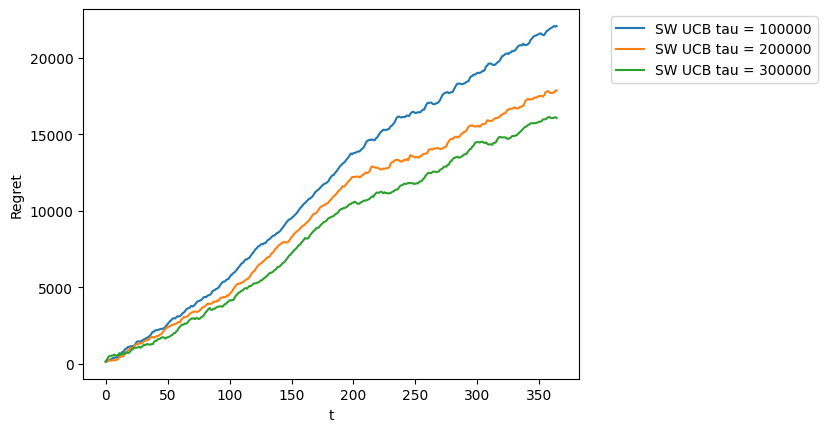

In [ ]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
min = -1
min_ind = -1
for i in range(0, len(taus)):
    cumsum = np.cumsum(opt - sw_rewards_per_tau[i])
    if min > cumsum[-1] or min==-1:
        min = cumsum[-1]
        min_ind = i
    plt.plot(cumsum)
plt.legend(["SW UCB tau = " + str(taus[i]) for i in range(0, len(taus))], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
print("SW UCB tau = " + str(taus[min_ind]))

SW UCB tau = 200000


In [ ]:
# experiments
n_experiments = 10
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
sw_ucb_rewards_per_experiment = []
count_time_horizon = 0

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = NonStationnary(n_arms = n_prices,
                       probabilities = p,
                       bids = bids,
                       average_number_of_clicks = clicks,
                       average_cum_daily_cost = costs,
                       noise_clicks = sigma_clicks,
                       noise_cost = sigma_costs,
                       time_abrupt_change_1 = time_abrupt_change_1,
                       time_abrupt_change_2 = time_abrupt_change_2)
  ts_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  ucb_learner = UCB_Pricing_Learner(n_arms = n_prices,
                                    prices = prices)
  # We play the best tau
  #tau = taus[min_ind]
  tau =  int((clicks(opt_bid_0) * T * n_experiments))
  print(tau) 

  sw_learner = SW_UCB_Pricing_Learner(n_arms = n_prices, prices=prices, tau=tau)


  ts_collected_costs = np.array([])
  ucb_collected_costs = np.array([])
  ts_daily_pricing_reward = np.array([])
  ucb_daily_pricing_reward = np.array([])
  sw_ucb_collected_costs = np.array([])
  sw_ucb_daily_pricing_reward = np.array([])

  for t in range(0,T):  # cycle on time horizon

    # TS
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ts_collected_costs = np.append(ts_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ts_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      ts_learner.update(pulled_price, reward_price)
    ts_daily_pricing_reward = np.append(ts_daily_pricing_reward,(reward_click>0)*np.sum(ts_learner.collected_rewards[-reward_click:]))


    # UCB
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ucb_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      ucb_learner.update(pulled_price, reward_price)
    ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,(reward_click>0)*np.sum(ucb_learner.collected_rewards[-reward_click:]))

    # SW UCB
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    sw_ucb_collected_costs = np.append(sw_ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      count_time_horizon += 1
      pulled_price = sw_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price, t)
      sw_learner.update(pulled_price, reward_price)
    sw_ucb_daily_pricing_reward = np.append(sw_ucb_daily_pricing_reward,(reward_click>0)*np.sum(sw_learner.collected_rewards[-reward_click:]))
    count_time_horizon += 1
  count_time_horizon += 1
  ts_rewards_per_experiment.append(ts_daily_pricing_reward - ts_collected_costs)
  ucb_rewards_per_experiment.append(ucb_daily_pricing_reward - ucb_collected_costs)
  sw_ucb_rewards_per_experiment.append(sw_ucb_daily_pricing_reward - sw_ucb_collected_costs)
print(count_time_horizon)

  0%|          | 0/10 [00:00<?, ?it/s]

303272


 10%|█         | 1/10 [00:11<01:41, 11.29s/it]

303272


 20%|██        | 2/10 [00:22<01:29, 11.13s/it]

303272


 30%|███       | 3/10 [00:33<01:18, 11.18s/it]

303272


 40%|████      | 4/10 [00:45<01:09, 11.56s/it]

303272


 50%|█████     | 5/10 [00:57<00:57, 11.51s/it]

303272


 60%|██████    | 6/10 [01:08<00:45, 11.31s/it]

303272


 70%|███████   | 7/10 [01:18<00:33, 11.15s/it]

303272


 80%|████████  | 8/10 [01:29<00:22, 11.04s/it]

303272


 90%|█████████ | 9/10 [01:40<00:11, 11.09s/it]

303272


100%|██████████| 10/10 [01:52<00:00, 11.24s/it]

304844


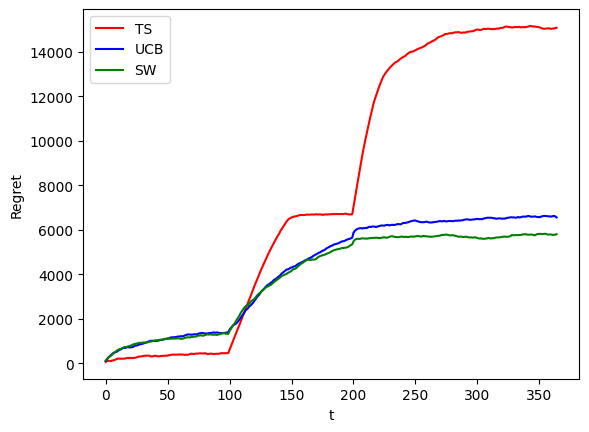

In [ ]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.plot(np.cumsum(np.mean(opt - sw_ucb_rewards_per_experiment, axis = 0)), 'g')
plt.legend(["TS", "UCB", "SW"])